In [272]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from graphviz import Digraph

from random import randrange, random
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, precision_score, recall_score, accuracy_score
from sklearn.tree import DecisionTreeClassifier

from sklearn.ensemble import RandomForestClassifier, BaggingClassifier
from sklearn.datasets import load_iris, load_wine
from sklearn.tree import export_graphviz
from IPython.display import Image
np.random.seed(42)

import matplotlib as mpl
mpl.rcParams.update({
    'font.size'           : 13,
    'axes.titlesize'      : 'large'
})

## Success Criteria

#### Today I will be successful if I can...
1. Explain bagging in one or two sentences
1. Express why Random Forests work better than traditional Bagging
1. Explain how increasing “n_estimators” will effect the random forest model’s variance

In [493]:
# Load wine data
wine_data = load_wine()

#put dataset into data frame
X = pd.DataFrame(wine_data['data'], columns=wine_data.feature_names)
y = pd.Series(wine_data.target)
# X = X.iloc[:,3:]
X.head()

,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline
0,14.23,1.71,2.43,15.6,127.0,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065.0
1,13.20,1.78,2.14,11.2,100.0,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050.0
2,13.16,2.36,2.67,18.6,101.0,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185.0
3,14.37,1.95,2.50,16.8,113.0,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480.0
4,13.24,2.59,2.87,21.0,118.0,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735.0


In [494]:
#take a look at our classes
y.unique()

array([0, 1, 2])

# Part 1

In [440]:
#train test split to enable model evaluation
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33,random_state=42)

In [496]:
#n_estimators will allow us to look at ensembling various numbers of trees
n_estimators = np.arange(5, 51, 5)

mean_train_accs = []
mean_test_accs = []

for n_trees in n_estimators:
    #create n_trees number of trees ... stored in a list
    trees = [DecisionTreeClassifier(max_depth = 2, random_state=42) for tree in range(n_trees)]
    #fit each tree in list using training data
    fits = [tree.fit(X_train, y_train) for tree in trees]
    
    #predict training and testing classes
    y_hats_train  = [tree.predict(X_train) for tree in trees]
    y_hats_test  = [tree.predict(X_test) for tree in trees]
    
    #chechout training and testing accuracy for each tree in list
    test_accs = [accuracy_score(y_test, y_hat) for y_hat in y_hats_test]
    train_accs = [accuracy_score(y_train, y_hat_train) for y_hat_train in y_hats_train]
    #since we have 5, 10, 15... trees in list we can average 
    #their accuracies to see how increased tree number
    #effects final score in model
    mean_train_accs.append(np.mean(train_accs))
    mean_test_accs.append(np.mean(test_accs))

### Decision tree for Classification
    
    
    
* Consider all binary splits based on a single feature:
    * if the feature is categorical, split on value or not value.
    * if the feature is numeric, split at a threshold: >threshold or <=threshold 
* Consider every possible split of every feature at every value
* Pick the one split that provides the best information gain (entropy/gini impurity)
* Use that split to create two new nodes and consider splitting them on every possible feature/value.
* Stop when all nodes are pure or other stopping conditions like depth limit are met
* Prune trees by merging nodes (ie., canceling a split)


#### So what would two decision trees look like if they were trained on the same data?

In [368]:
#get a nice visual of the decision trees
def get_viz(tree, names = wine_data.target_names, feat_names = X.columns):
    #use graphviz to create a decision tree viz
    export_graphviz(tree, out_file='../images/tree.dot', feature_names = feat_names,
                class_names = names,
                rounded = True, proportion = False, precision = 2, filled = True)
    #convert dot to png
    !dot -Tpng ../images/tree.dot -o ../images/tree.png
    return Image('../images/tree.png')

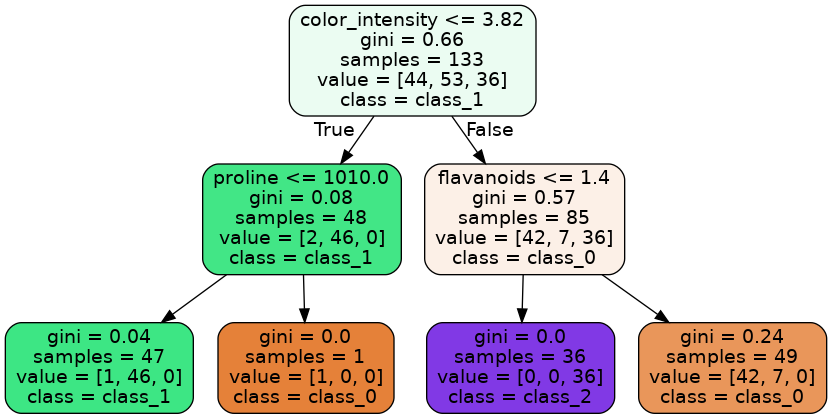

In [369]:
get_viz(trees[0])

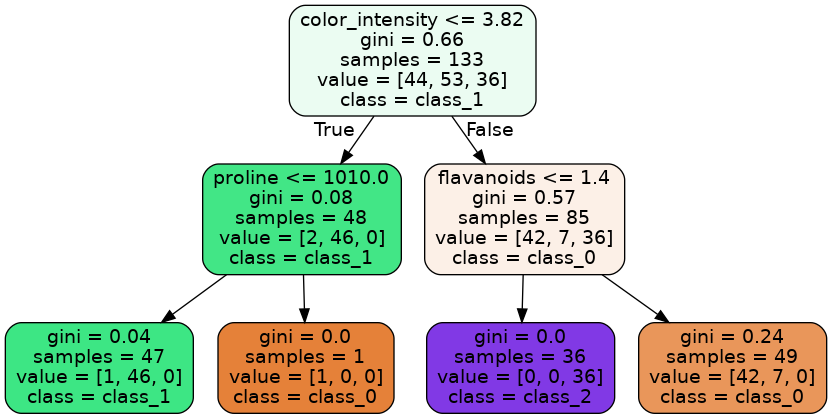

In [370]:
get_viz(trees[10])

We get the exact same tree over and over... so we have an opportunity to get creative and get some variation with our trees.

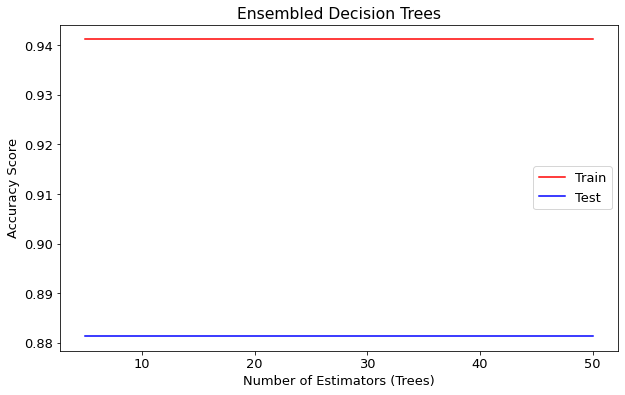

In [511]:
#plot accuracies accross varied num trees
plt.figure(figsize=(10,6))
plt.plot(list(n_estimators), mean_train_accs, label = 'Train', c='red', )
plt.plot(list(n_estimators), mean_test_accs, label = 'Test', c = 'blue')
plt.xlabel('Number of Estimators (Trees)')
plt.ylabel('Accuracy Score')
plt.title('Ensembled Decision Trees')
plt.legend();

# Part 2

## Lets Try Bagging

#### Bagging (Bootstrap + Aggregating)
1. take bootstrapped samples of data (n_estimators determine how many samples to bootstrap)
1. train chosen estimator/model continously from the bootstrapped datasets
1. Average/Vote on all of the estimators to return a prediction

In [526]:
#sklearn provides a bagging method
n_estimators = np.arange(5, 201, 5)

train_accs = []
test_accs = []

basetree = DecisionTreeClassifier(max_depth = 2, random_state=123)

for n_trees in n_estimators:
    bag = BaggingClassifier(base_estimator=basetree, n_estimators=n_trees)
    bag.fit(X_train, y_train)
    y_hats_test =  bag.predict(X_test)
    y_hats_train =  bag.predict(X_train)

    train_accs.append(accuracy_score(y_hats_train, y_train)) 
    test_accs.append(accuracy_score(y_hats_test, y_test))

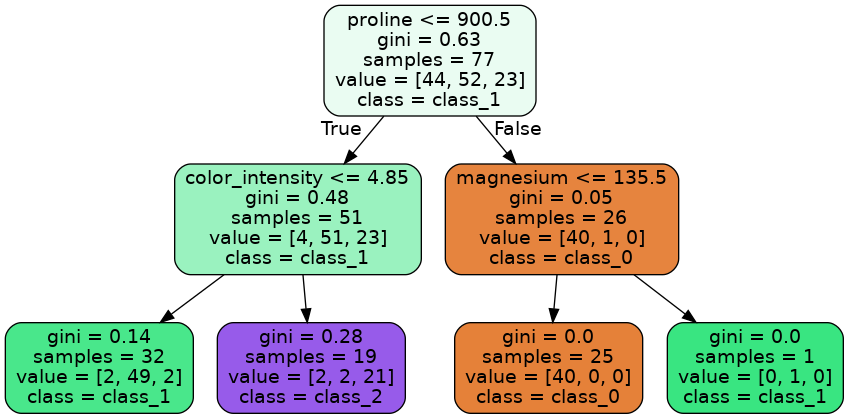

In [530]:
get_viz(bag.estimators_[5])

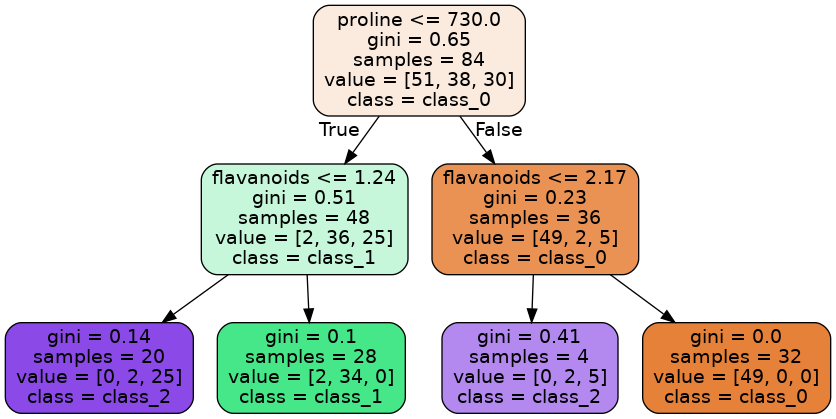

In [531]:
get_viz(bag.estimators_[1])

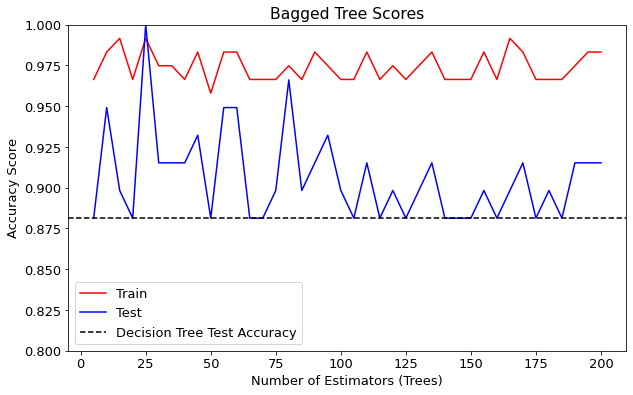

In [532]:
#plot accuracies accross different num trees
plt.figure(figsize=(10,6))
plt.plot(list(n_estimators), train_accs, label = 'Train', c='red')
plt.plot(list(n_estimators), test_accs, label = 'Test', c = 'blue')
plt.axhline(np.mean(mean_test_accs), ls = '--', label = 'Decision Tree Test Accuracy', c = 'k')
plt.xlabel('Number of Estimators (Trees)')
plt.ylabel('Accuracy Score')
plt.title('Bagged Tree Scores')
plt.ylim(0.8,1)
plt.legend();

# Part 3

## Time for a Random Forest

In the above visuals, we see that there is still quite a bit of similarity between our bagged trees. Highly independent trees are going to get us a more accurate ensemble method, this is where the **"Random"** for Random Forest comes in!

To decorrelate the trees even more than bagging, we decide not to consider every feature for each split. The **features are randomly chosen at each split** in each tree. 

The *max_features* parameter helps change the number of considered features. In sklearn, max_features is set to 'auto' which is the square root of the number of features available in the dataset. 




In [450]:
n_estimators = np.arange(1,200, 5)
train_accs_rf = []
test_accs_rf = []
for n_trees in n_estimators:
    rf = RandomForestClassifier(n_estimators=n_trees, max_depth=2, random_state=12)
    rf.fit(X_train, y_train)
    y_hats_test =  rf.predict(X_test)
    y_hats_train =  rf.predict(X_train)
    train_accs_rf.append(accuracy_score(y_hats_train, y_train)) 
    test_accs_rf.append(accuracy_score(y_hats_test, y_test))

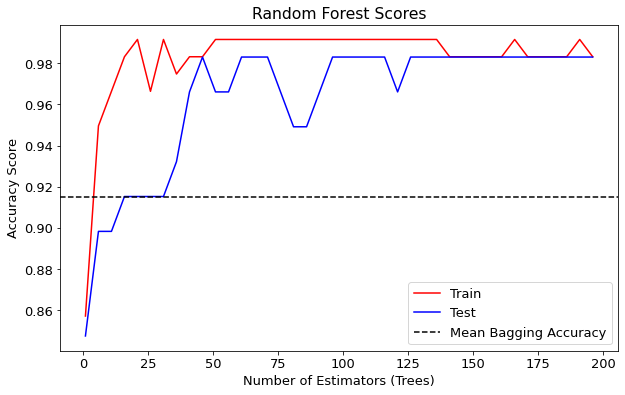

In [451]:
plt.figure(figsize=(10,6))
plt.plot(list(n_estimators), train_accs_rf, label = 'Train', c='red', )
plt.plot(list(n_estimators), test_accs_rf, label = 'Test', c = 'blue')
plt.axhline(np.median(test_accs), ls = '--', c = 'k', label = 'Mean Bagging Accuracy')
plt.xlabel('Number of Estimators (Trees)')
plt.ylabel('Accuracy Score')
plt.title('Random Forest Scores')
# plt.ylim(0.4)
plt.legend();

#### It is typical that a Random Forest with more trees will return higher accuracy or R^2 but with diminishing returns. 

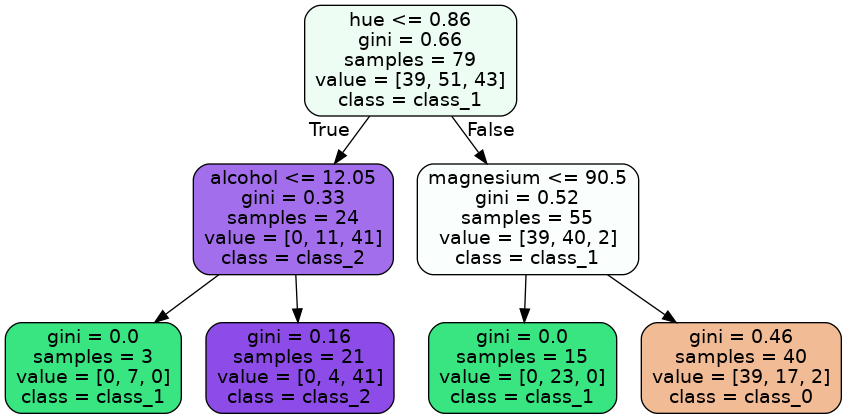

In [379]:
get_viz(rf.estimators_[0])

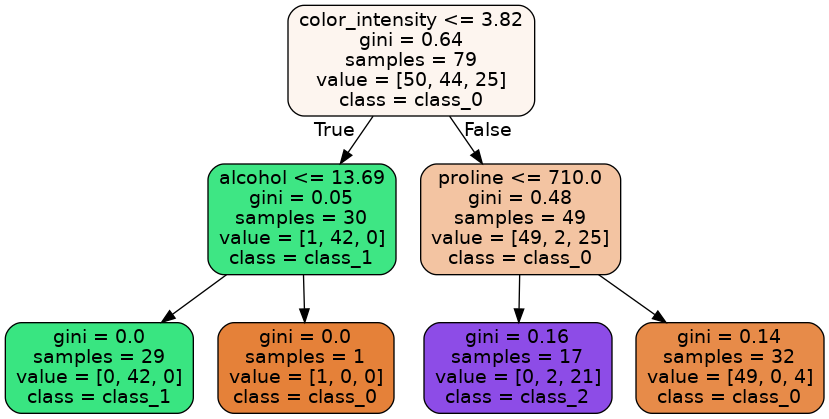

In [523]:
get_viz(rf.estimators_[1])

#### Questions

1. In a Random Forest, are features chosen at each tree or at each split?
1. When creating a Random Forest, how do you determine how many trees you should use?
1. Would Random Forest work for regression as well as classification problems, why?

### Random Forest Strengths and Weaknesses

Pros:
1. One of most accurate learning algorithms available
1. No need for feature scaling
1. works for nonlinear relationships
1. Maintains accuracy even when a large proportion of data is missing

Cons:
1. expensive to train (although it can be done in parallel) 
1. not as interpretable as other models we have discussed (lack of transparency in the process)

### Parameters for Random Forest
* n_estimators (number of trees)
* max_features (number of features to consider at each split)
* Any Decision tree Parameter
* OOB_score (whether to use out of bag score to generalize accuracy/R^2)



##### OOB_score parameter explained
* Each bootstrapped sample in the Random Forest classifier is trained on slightly different data and for each Decision Tree within the Random Forest, we have a holdout set called **"out of bag sample"**.

* These samples will be predicted on for the other Decision Trees that did not contain the specific sample. 
* The final prediction of a row is determined by the "majority vote" or "mean" of all available DT predictions.
* The OOB score is computed as the number of correctly predicted rows from the out of bag sample.


In [476]:
rf = RandomForestClassifier(max_depth=2, n_estimators = 50, oob_score=True, random_state=12)
rf.fit(X_train, y_train)
y_hat = rf.predict(X_test)
accuracy_score(y_test, y_hat)
#quick "alternative" for cross validation score
rf.oob_score_

0.957983193277311

#### Next lecture will focus on finding ways to interpret out features through feature importance using *Leave one Out Feature Importance* and *partial dependence plots*